In [1]:
from __future__ import print_function, division
import os
import tarfile
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.ion()   # interactive mode

In [4]:
photo_base = tarfile.open("yelp_photos.tar")

In [5]:
photos_regions = pd.read_csv('yelp_data/business_restaurant_train.csv')

In [6]:
n = 6
img_name = photos_regions.iloc[n, 0]
is_restaurant = 'A restaurant' if photos_regions.iloc[n, 2] else 'Not a restaurant'
print('Image name: {}'.format(img_name))
print(is_restaurant)

Image name: -Pb9DpGZcd6AOK34DYFgMg
Not a restaurant


In [7]:
def show_image(image, is_restaurant):
    plt.imshow(image)
    plt.title(is_restaurant)
    plt.pause(0.001)  # pause a bit so that plots are updated

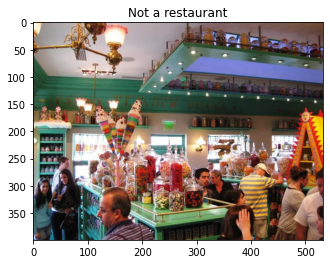

In [8]:
plt.figure()
show_image(io.imread(photo_base.extractfile(os.path.join('photos/', img_name + '.jpg'))), is_restaurant)
plt.show()

In [9]:
class IsRestaurantDataset(Dataset):
    """Is It A Restaurant Dataset."""

    def __init__(self, csv_file, photo_tar, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            photo_tar (string): Tar file with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.business_frame = pd.read_csv(csv_file)
        self.photo_tar = tarfile.open(photo_tar)
        self.transform = transform

    def __len__(self):
        return len(self.business_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join('photos/',
                                self.business_frame.iloc[idx, 0] + '.jpg')
        image = io.imread(self.photo_tar.extractfile(img_name))
        is_restaurant = self.business_frame.iloc[idx, 2]
        is_restaurant = np.array([not is_restaurant, is_restaurant]).astype(int)
        sample = {'image': image, 'is_restaurant': is_restaurant}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (400, 300, 3) [0 1]


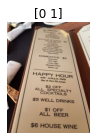

1 (400, 300, 3) [0 1]


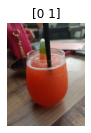

2 (337, 600, 3) [0 1]


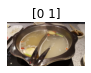

3 (400, 400, 3) [0 1]


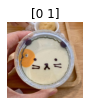

In [10]:
business_dataset = IsRestaurantDataset(csv_file='yelp_data/business_restaurant_train.csv',
                                       photo_tar='yelp_photos.tar')

fig = plt.figure()

for i in range(len(business_dataset)):
    sample = business_dataset[i]

    print(i, sample['image'].shape, sample['is_restaurant'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(**sample)

    if i == 3:
        plt.show()
        break

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, is_restaurant = sample['image'], sample['is_restaurant']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'is_restaurant': is_restaurant}

In [12]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, is_restaurant = sample['image'], sample['is_restaurant']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'is_restaurant': is_restaurant}

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, is_restaurant = sample['image'], sample['is_restaurant']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'is_restaurant': torch.from_numpy(is_restaurant)}

In [14]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

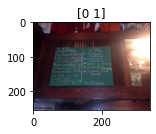

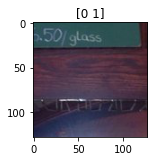

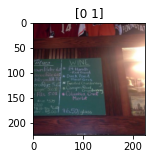

In [15]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = business_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(**transformed_sample)

plt.show()

In [16]:
transformed_dataset = IsRestaurantDataset(csv_file='yelp_data/business_restaurant_train.csv',
                                          photo_tar='yelp_photos.tar',
                                          transform=transforms.Compose([
                                          Rescale(256),
                                          RandomCrop(224),
                                          ToTensor()
                                          ]))

In [17]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['is_restaurant'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor([0, 1])
1 torch.Size([3, 224, 224]) tensor([0, 1])
2 torch.Size([3, 224, 224]) tensor([0, 1])
3 torch.Size([3, 224, 224]) tensor([0, 1])


In [18]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

In [19]:
# Helper function to show a batch
def show_business_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, business_batch = \
            sample_batched['image'], sample_batched['is_restaurant']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])
1 torch.Size([4, 3, 224, 224]) tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])
2 torch.Size([4, 3, 224, 224]) tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])
3 torch.Size([4, 3, 224, 224]) tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])


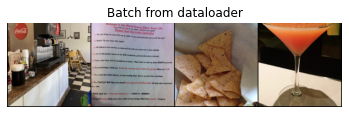

In [22]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['is_restaurant'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_business_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break